In [1]:
"""
Imports
"""
import numpy as np
from hlxon_hdf5io import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from filters.HelixonKalmanFilter import *
from metrics import *
import time
from model.spiral_model import *


"""
Load Data
"""
dataset = readAll()

In [2]:
# creating spiral model
spiral_pitch = 4.2 #m
spiral_radius = 8 #m
path_width = 2.4 #m
spiral = Spiral(spiral_pitch, spiral_radius, path_width)

# Evaluation of Wi-Fi based Random Forest Implementation

In [3]:
"""
Load Model
"""
from pickle import load
with open(os.path.join("model", "wifi_model.pkl"), "rb") as f:
    best_rf = load(f)

"""
Load BSSID mapping
"""
with open(os.path.join("model", "bssid_map.pkl"), "rb") as f:
    bssidMap = load(f)



c:\Users\Yusuf\miniconda3\envs\rnd\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Yusuf\AppData\Local\Temp\ipykernel_32596\1172206874.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._from

In [4]:


"""
Preprocess Data and Split Data
"""
Xs = []
ys = []

for sequence in dataset:
    _, _, _, _, _, _, wifidata, gt_timestamp, gt_position, _ = sequence
    ts = np.array([row[0] for row in wifidata])
    cnts = np.array([row[1] for row in wifidata])
    bssids = np.array([[np.argmax(row[i].decode() == bssidMap) for i in range(2, len(row), 2)] for row in wifidata]) # mapped to indices here
    rssis = np.array([[row[i] for i in range(3, len(row), 2)]  for row in wifidata])

    Z = 2
    positions = np.array(gt_position)[:, :]
    gt_ts = np.array(gt_timestamp)

    N = len(wifidata)

    # interpolate over timestamps
    lerped_positions = np.zeros((N, 3))
    for i in range(N):
        if ts[i] in gt_ts:
            lerped_positions[i] = positions[np.argmax(gt_ts == ts[i])]
        else:
            # lerp
            ix_2 = np.argmax(gt_ts > ts[i])
            ix_1 = gt_ts.shape[0] - np.argmax(np.flip(gt_ts, axis=0) < ts[i]) - 1
            

            # lerp formula: y12 = y1 + (t12 - t1) * (y2-y1)/(t2-t1 + stability epsilon)
            lerped_positions[i] = positions[ix_1] + (ts[i]-gt_ts[ix_1])*(positions[ix_2] - positions[ix_1])/(gt_ts[ix_2] - gt_ts[ix_1] + 1e-9)


    # define inputs and outputs
    Xi = np.ones((N, bssidMap.shape[0])) * -100
    rssis = rssis.reshape((N, -1))
    for i in range(N):
        indices = bssids[i]
        for j, k in enumerate(indices):
            Xi[i][k] *= 0
            Xi[i][k] += rssis[i][j]

    yi = lerped_positions

    Xs += [Xi]
    ys += [yi]

# split data
X = np.concatenate(Xs[:-1])
y = np.concatenate(ys[:-1])

X_unseen, y_unseen = Xs[-1], ys[-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)


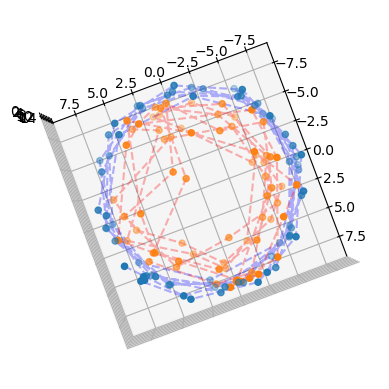

In [5]:
"""
Plot Results (Qualitative)
"""
X, Y, Z = 0, 1, 2
fig = plt.figure()
ax = plt.axes(projection='3d')

y_pred = best_rf.predict(X_unseen)

ax.scatter(y_unseen[:, X], y_unseen[:, Y], y_unseen[:, Z], 'blue')
ax.plot(y_unseen[:, X], y_unseen[:, Y], y_unseen[:, Z], color=(0., 0., 1., 0.3), linestyle='--')


ax.scatter(y_pred[:, X], y_pred[:, Y], y_pred[:, Z], 'red')
ax.plot(y_pred[:, X], y_pred[:, Y], y_pred[:, Z], color=(1., 0., 0., 0.3), linestyle='--')
ax.view_init(270, 20)
plt.show()

# Evaluation of Pressure and Kalman Filtering Based Positioning

## Height Kalman Filter Definition

In [6]:
# --------------------------------
# kalman filter
# --------------------------------
"""
State Vector

format:
    - [0:3] position z (meters global coords)
    - [6:9] velocity z (m/s global coords)
"""

# P (measurement cov mat)
P = np.identity(2) * .01
# Q (process noise)
Q = np.identity(2) * .1
# R (measurement noise)
R = np.identity(1) * 1.
# H (measurement matrix)
H = np.array([
    [ 1., 0. ], 
])

# function to get A (state transition matrix) for certain dt
def getA(dt: float):
    return np.array([
        [1., dt],  # Height
        [0., 1.]   # Velocity
    ])

# function to get B (control transition matrix) for certain dt
def getB(dt: float):
    return np.array([
        [0.5 * dt**2],  # Height
        [dt]            # Velocity
    ])


kf = HelixonKalmanFilter(getA, getB, P, Q)

## Qualitative and Quantitative Results Over 1 Sequence

In [7]:
# get data from hdf5
raw_timestamp, raw_9dof, raw_rpy, raw_bno, raw_bmp, raw_pressure, wifidata, gt_timestamp, gt_position, gt_orientation = dataset[2]

# convenience
Z = 2
N = len(raw_timestamp) 

# remove offsets gt pos and orientation
gt_position = np.array(gt_position)
gt_position -= gt_position[0]

# get sensor data
araw = np.array(raw_9dof[:, :3])
pres = np.array(raw_pressure).reshape((-1, 1))
alpha = 1.16e-4
ts = np.array(raw_timestamp)*1e-6
gt_timestamp = np.array(gt_timestamp)*1e-6

# define p0
p0 = np.mean(raw_pressure[:200])
pres[np.where(pres > p0)] = p0

# load accels
accel = np.array(araw)
global_accel_z = accel[:,Z].reshape(N, 1, 1)

# all ys (measurements) for kalman filter
heights = np.log(pres/p0)/(-alpha)
ys = heights

# all us (control inputs) for kalman filter
us = global_accel_z

kalman filter ATE: 0.3050151876827519 RTE: 0.41523174913032534
heights ATE: 0.30574743500047746 RTE: 0.4198623582188678


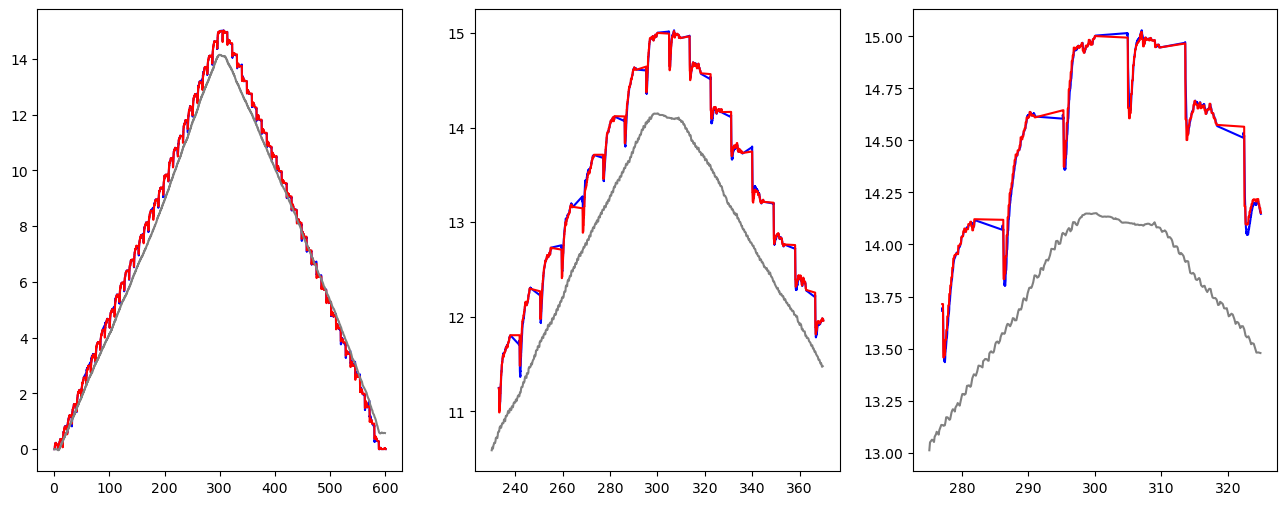

In [8]:
# Run Kalman Filter offline
predicted_heights = kf.run_offline(us, ys, H, R, ts)[:, 0].reshape(-1, 1)
predicted_positions = []
for height in predicted_heights:
    predicted_positions.append(spiral.point_at_z(height))
predicted_positions = np.array(predicted_positions)

# ATE and RTE for heights only
ateKALMAN, rteKALMAN = compute_ate_rte(np.concatenate((np.array(ts).reshape((-1, 1)), predicted_heights*np.array([0, 0, 1])), axis=1), 
                                    np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position*np.array([0, 0, 1])), axis=1))

ateH, rteH = compute_ate_rte(np.concatenate((np.array(ts).reshape((-1, 1)), heights*np.array([0, 0, 1])), axis=1), 
                        np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position*np.array([0, 0, 1])), axis=1))

print(f'kalman filter ATE: {ateKALMAN} RTE: {rteKALMAN}\nheights ATE: {ateH} RTE: {rteH}')

# plot heights as functions of time
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
ax1.plot(ts, predicted_heights[:, 0], 'blue')
ax1.plot(ts, heights.flatten(), 'red')
ax1.plot(gt_timestamp, gt_position[:, 2], 'gray')

t_start, t_end = 230, 370 
ixraw_1 = np.argmax(ts > t_start)
ixraw_2 = ixraw_1 + np.argmax(ts[ixraw_1:] > t_end)
ixgt_1 = np.argmax(gt_timestamp > t_start)
ixgt_2 = ixgt_1 + np.argmax(gt_timestamp[ixgt_1:] > t_end)

ax2.plot(ts[ixraw_1:ixraw_2], predicted_heights[ixraw_1:ixraw_2, 0], 'blue')
ax2.plot(ts[ixraw_1:ixraw_2], heights.flatten()[ixraw_1:ixraw_2], 'red')
ax2.plot(gt_timestamp[ixgt_1:ixgt_2], gt_position[ixgt_1:ixgt_2, 2], 'gray')

t_start, t_end = 275, 325 
ixraw_1 = np.argmax(ts > t_start)
ixraw_2 = ixraw_1 + np.argmax(ts[ixraw_1:] > t_end)
ixgt_1 = np.argmax(gt_timestamp > t_start)
ixgt_2 = ixgt_1 + np.argmax(gt_timestamp[ixgt_1:] > t_end)

ax3.plot(ts[ixraw_1:ixraw_2], predicted_heights[ixraw_1:ixraw_2, 0], 'blue')
ax3.plot(ts[ixraw_1:ixraw_2], heights.flatten()[ixraw_1:ixraw_2], 'red')
ax3.plot(gt_timestamp[ixgt_1:ixgt_2], gt_position[ixgt_1:ixgt_2, 2], 'gray')
plt.show()

kalman filter ATE: 3.775544671397861 RTE: 6.524086267112995


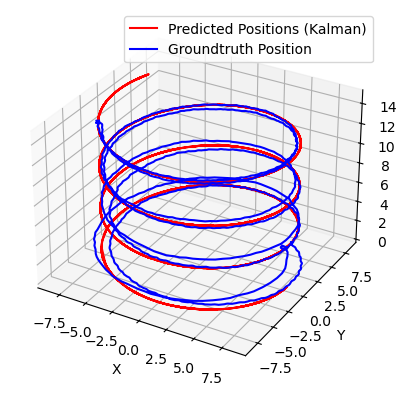

In [9]:
# Generating spiral from "raw heights"
predicted_positions = []
for height in predicted_heights:
    predicted_positions.append(spiral.point_at_z(height))

predicted_positions = np.array(predicted_positions)

# Aligning spirals at (x, y) = (0, 0)
predicted_positions = spiral.center_spiral(predicted_positions).reshape((-1, 3))
gt_position = spiral.center_spiral(gt_position)

# ATE and RTE for predictions
ateKALMAN, rteKALMAN = compute_ate_rte(np.concatenate((np.array(ts).reshape((-1, 1)), predicted_positions), axis=1), 
                                    np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position), axis=1))

print(f'kalman filter ATE: {ateKALMAN} RTE: {rteKALMAN}')

# Plotting predicted and gt spirals
fig = plt.figure()
ax = plt.axes(projection='3d')
predicted_positions = np.array(predicted_positions)  # Convert list to NumPy array
ax.plot3D(predicted_positions[:, 0], predicted_positions[:, 1], predicted_positions[:, 2], 'red', label='Predicted Positions (Kalman)')
ax.plot3D(gt_position[:, 0], gt_position[:, 1], gt_position[:, 2], 'blue', label='Groundtruth Position')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

## Full evaluation of performance over dataset

In [10]:
ates_nokalman = []
rtes_nokalman = []
avg_nokalman = []

ates_kwifi = []
rtes_kwifi = []
avg_kwifi = []

ates_kalman = []
rtes_kalman = []
avg_kalman = []

"""
Kalman Filter Definition

State Vector

format:
    - [0:3] positions x y z (meters global coords)
    - [0:6] velocities x y z (m/s global coords)
"""

# P (measurement cov mat)
P = np.identity(6) * .01
# Q (process noise)
Q = np.identity(6) * 30
# R (measurement noise)
R_PRESSURE = np.diag([10., 10., 1.]) * 1
R_WIFI = np.diag([1., 1., 100.]) * 10000
# H (measurement matrix)
H_PRESSURE = np.array([
    [1., 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0.], 
    [0., 0., 1., 0., 0., 0.], 
])
H_WIFI = np.array([
    [1., 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0.], 
    [0., 0., 1., 0., 0., 0.], 
])

# function to get A (state transition matrix) for certain dt
def getA(dt: float):
    return np.array([
# positions ||   velos   |   
[1., 0., 0.,  dt, 0., 0. ],  # px
[0., 1., 0.,  0., dt, 0. ],  # py 
[0., 0., 1.,  0., 0., dt ],  # pz
[0., 0., 0.,  1., 0., 0. ],  # vx
[0., 0., 0.,  0., 1., 0. ],  # vy
[0., 0., 0.,  0., 0., 1. ],  # vz
    ])

# function to get B (control transition matrix) for certain dt
def getB(dt: float):
    return np.array([
#               accels              |
[.5*dt**2,  0.,         0.         ],  # px
[0.,        .5*dt**2,   0.         ],  # py 
[0.,        0.,         .5*dt**2   ],  # pz 
[dt,        0.,         0.         ],  # vx
[0.,        dt,         0.         ],  # vy
[0.,        0.,         dt         ],  # vz
    ])




In [11]:

print('Processing', end='')
for sequence in dataset:
    print('.', end='')
    # get data from hdf5
    raw_timestamp, raw_9dof, raw_rpy, raw_bno, raw_bmp, raw_pressure, wifidata, gt_timestamp, gt_position, gt_orientation = sequence

    """
    Preprocess some data
    """
    # convenience
    X, Y, Z = 0, 1, 2
    N = len(raw_timestamp)

    # process wifi data
    wifi_timestamp = np.array([row[0] for row in wifidata])*1e-6
    wifi_cnts = np.array([row[1] for row in wifidata])
    bssids = np.array([[row[i].decode() for i in range(2, len(row), 2)] for row in wifidata])
    rssis = np.array([[row[i] for i in range(3, len(row), 2)]  for row in wifidata])

    # get sensor data
    araw = np.array(raw_9dof[:, :3])
    gyro = np.array(raw_9dof[:, 3:6])
    magn = np.array(raw_9dof[:, 6:])
    pres = np.array(raw_pressure).reshape((-1, 1))
    alpha = 1.16e-4
    ts = np.array(raw_timestamp)*1e-6
    gt_timestamp = np.array(gt_timestamp)*1e-6

    # p0 is average of first 200
    p0 = np.mean(raw_pressure[:200])
    pres[np.where(pres > p0)] = p0

    # remove offsets gt pos
    offset =  gt_position[0]
    gt_position = np.array(gt_position)
    gt_position -= offset

    # load accels
    accel = araw

    # align spiral model to this spiral
    spiral.align_to_spiral(gt_position)

    """
    create filter objects
    """

    kf = HelixonKalmanFilter(getA, getB, P, Q)
    kf_nowifi = HelixonKalmanFilter(getA, getB, P, Q)

    
    """
    hasNext and getNext functions to iterate over all data (imu and wifi) ordered by their timestamps
    """
    ix_raw = 1
    ix_wifi = 1
    def hasNext():
        return ix_raw < len(ts) or ix_wifi < len(wifi_timestamp)

    def getNext():
        global ix_raw 
        global ix_wifi
        
        # decide what to output next based on their timestamps
        WIFINEXT = 1
        RAWNEXT = 0
        if ix_raw >= len(ts):
            nexttype = WIFINEXT
        elif ix_wifi >= len(wifi_timestamp):
            nexttype = RAWNEXT
        else:
            nexttype = np.argmin([ts[ix_raw], wifi_timestamp[ix_wifi]])

        # output data
        if nexttype == RAWNEXT: # raw
            ix_raw += 1
            ti = ts[ix_raw-1]
            dt = ti-ts[ix_raw-2]
            return 'raw', (accel[ix_raw-1, :3], pres[ix_raw-1], dt, ti)
        
        elif nexttype == WIFINEXT: # wifi
            ix_wifi += 1
            ti = wifi_timestamp[ix_wifi-1]

            # map bssid data to model format
            dout = np.ones((1, bssidMap.shape[0])) * -100
            for bssid, rssi in zip(bssids[ix_wifi-1], rssis[ix_wifi-1]):
                if bssid in bssidMap:
                    ix = np.argmax(bssidMap == bssid)
                    dout[0, ix] *= 0
                    dout[0, ix] += rssi

            return 'wifi',  (dout, ti)

    """
    Execute Kalman filter
    """
    pos = []
    twifi = []
    tnowifi = []
    posheights = []
    pwifi = []
    while hasNext():
        datatype, data = getNext()
        
        if datatype == 'raw':
            # reorganize data
            data, presval, dt, ti = data

            # predict step
            data = np.array(data).reshape((3, 1))
            kf.predict(data, dt)
            kf_nowifi.predict(data, dt)

            # update step
            height = np.array(np.log(presval/p0)/(-alpha)).reshape((1, 1))
            ph = spiral.point_at_z(height)
            posheights += [ph.flatten()]
            kf.update(ph.reshape((3, 1)), H_PRESSURE, R_PRESSURE)
            kf_nowifi.update(ph.reshape((3, 1)), H_PRESSURE, R_PRESSURE)

            pos += [kf_nowifi.xhat.flatten()[:3]]
            tnowifi += [ti]


        if datatype == 'wifi':
            # reorganize data
            data, ti = data
            position = best_rf.predict(data)[0]

            # update
            position = np.array(position).flatten()
            input = position.reshape((3, 1))
            kf.update(input, H_WIFI, R_WIFI)


        pwifi += [kf.xhat.flatten()[:3]]
        twifi += [ti]

    pos = np.array(pos)
    pwifi = np.array(pwifi) - offset
    posheights = np.array(posheights)

    """
    Evaluate Results
    """
    ate, rte = compute_ate_rte(np.concatenate((np.array(twifi).reshape((-1, 1)), pwifi), axis=1), 
                                        np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position), axis=1))
    avg = compute_average_trajectory_error(np.concatenate((np.array(twifi).reshape((-1, 1)), pwifi), axis=1), 
                                        np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position), axis=1))

    ates_kwifi += [ate]
    rtes_kwifi += [rte]
    avg_kwifi += [avg]

    ate, rte = compute_ate_rte(np.concatenate((np.array(tnowifi).reshape((-1, 1)), pos), axis=1), 
                                        np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position), axis=1))
    avg = compute_average_trajectory_error(np.concatenate((np.array(tnowifi).reshape((-1, 1)), pos), axis=1), 
                                        np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position), axis=1))

    ates_kalman += [ate]
    rtes_kalman += [rte]
    avg_kalman += [avg]

    ate, rte = compute_ate_rte(np.concatenate((np.array(tnowifi).reshape((-1, 1)), posheights), axis=1), 
                                        np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position), axis=1))
    avg = compute_average_trajectory_error(np.concatenate((np.array(tnowifi).reshape((-1, 1)), posheights), axis=1), 
                                        np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position), axis=1))

    ates_nokalman += [ate]
    rtes_nokalman += [rte]
    avg_nokalman += [avg]

Processing...........

In [12]:
ates_nokalman = np.mean(ates_nokalman)
rtes_nokalman = np.mean(rtes_nokalman)
avg_nokalman = np.mean(avg_nokalman)
ates_kwifi = np.mean(ates_kwifi)
rtes_kwifi = np.mean(rtes_kwifi)
avg_kwifi = np.mean(avg_kwifi)
ates_kalman = np.mean(ates_kalman)
rtes_kalman = np.mean(rtes_kalman)
avg_kalman = np.mean(avg_kalman)

print('ates_nokalman: ', ates_nokalman)
print('rtes_nokalman: ', rtes_nokalman)
print('avg_nokalman: ', avg_nokalman)
print('ates_kwifi: ', ates_kwifi)
print('rtes_kwifi: ', rtes_kwifi)
print('avg_kwifi: ', avg_kwifi)
print('ates_kalman: ', ates_kalman)
print('rtes_kalman: ', rtes_kalman)
print('avg_kalman: ', avg_kalman)

ates_nokalman:  3.288115213666242
rtes_nokalman:  3.0146886140391227
avg_nokalman:  2.2576419516981954
ates_kwifi:  5.545541118272514
rtes_kwifi:  3.0794191079452884
avg_kwifi:  4.0758030696517045
ates_kalman:  3.286820616920572
rtes_kalman:  3.013164566084708
avg_kalman:  2.25690996422379
